Loading and processing data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from help import show_image_from_each_class, label_to_genre
import random
import pandas as pd

images = np.load("../data/processed/images.npy")
labels = np.load("../data/processed/labels.npy")
print(images.shape)
print(labels.shape)
input_shape = images.shape[1:]


(1000, 200, 200)
(1000, 10)


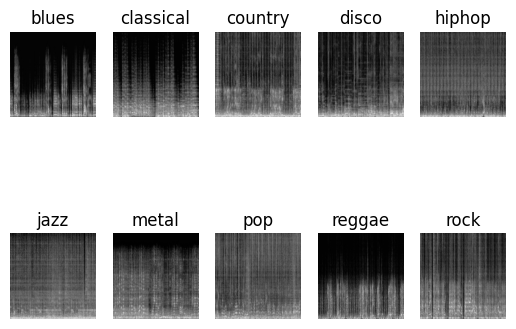

In [2]:
show_image_from_each_class(images)

In [3]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test set
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=1.0/3)
print("Train set length:" + str(len(x_train)))
print("Validation set length:" + str(len(x_valid)))
print("Test set length:" + str(len(x_test)))


Train set length:700
Validation set length:200
Test set length:100


Describing the model

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

num_classes = 10
inputs = Input(shape=(input_shape + (1,))) # Nicer way to add this 1 as a dimension?

# lamda is the weight of the L2 penalty term
lamda = 0.15
L2_regularizer = keras.regularizers.l2(lamda)
initializer = tf.keras.initializers.HeUniform()


# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = BatchNormalization()(inputs)
x = Conv2D(16, kernel_size=(7, 7), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)


x = Conv2D(32, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3))(x)

x = Dropout(0.5)(x)

x = Conv2D(16, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3))(x)

encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(16,kernel_regularizer=L2_regularizer)(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(32,kernel_regularizer=L2_regularizer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(16,kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()
# ********************************************* Model ********************************************

2022-10-27 15:07:51.356677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 15:07:51.356706: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 194, 194, 16)      800       
                                                                 
 batch_normalization_1 (Batc  (None, 194, 194, 16)     64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 194, 194, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 97, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 97, 97, 16)        0     

2022-10-27 15:07:52.725888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 15:07:52.726489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 15:07:52.726542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-27 15:07:52.726590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-27 15:07:52.728176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
learning_rate = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=0.1, first_decay_steps=100000, m_mul=0.9, alpha=0.01)
print(learning_rate.get_config())
def callback(batch):
    print("------- yoyoyoyo ---------")
    print(batch)
learning_rate.on_train_batch_begin = callback
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(momentum=0.9, nesterov=True, learning_rate=learning_rate),
              metrics=['accuracy'])

from tensorflow import keras



help(keras.callbacks.LearningRateScheduler.on_train_batch_begin)

{'initial_learning_rate': 0.1, 'first_decay_steps': 100000, 't_mul': 2.0, 'm_mul': 0.9, 'alpha': 0.01, 'name': None}
Help on function on_train_batch_begin in module keras.callbacks:

on_train_batch_begin(self, batch, logs=None)
    Called at the beginning of a training batch in `fit` methods.
    
    Subclasses should override for any actions to run.
    
    Note that if the `steps_per_execution` argument to `compile` in
    `tf.keras.Model` is set to `N`, this method will only be called every `N`
    batches.
    
    Args:
        batch: Integer, index of batch within the current epoch.
        logs: Dict. Currently no data is passed to this argument for this method
          but that may change in the future.



In [18]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(x_valid, y_valid),
          shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
11/11 [==============================] - 23s 2s/step - loss: 8.2281 - accuracy: 0.1329 - val_loss: 3.6231 - val_accuracy: 0.0800
Epoch 2/10
 3/11 [=======>......................] - ETA: 15s - loss: 3.6796 - accuracy: 0.1927

KeyboardInterrupt: 

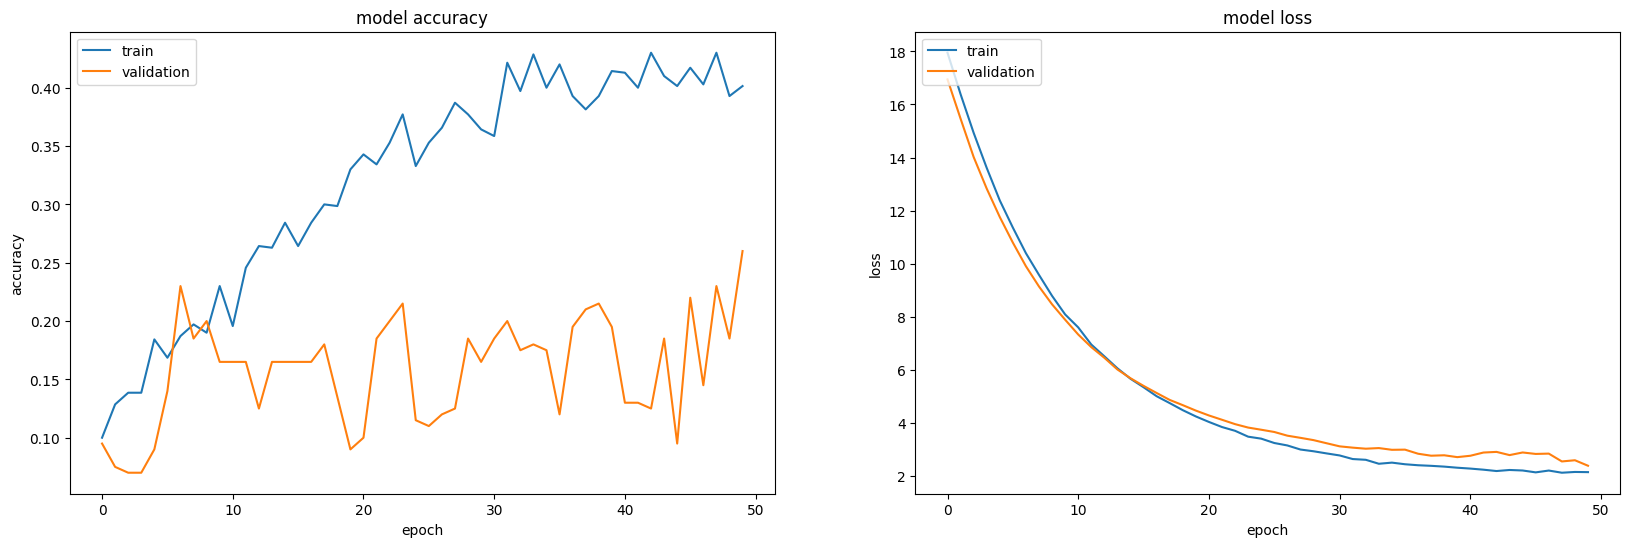

In [23]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

(7, 7, 1, 16)


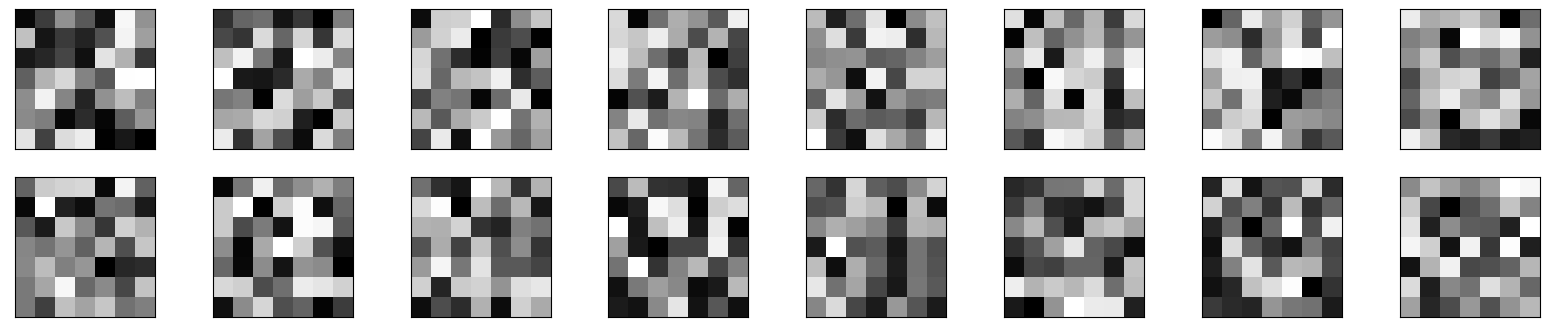

In [42]:
# Displaying the last weights
W = np.asarray(model.layers[1].get_weights()[0])
n_filters = W.shape[3]
print(W.shape)
W = W.reshape((*W.shape[:2], n_filters))
plt.figure(figsize=(20,4))
for i in range(n_filters):
  ax = plt.subplot(2, (n_filters + 1) // 2, i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

In [67]:
predictions = model.predict(x_test)

def top1_error(preds,labels):
  return np.mean(np.argmax(preds,axis=1) != np.argmax(labels,axis=1))

print("Top-1 error is: " + str(top1_error(predictions,y_test[:len(predictions)])))


def top5_error(preds,labels):
  argsorted = np.argsort(np.argsort(preds,axis=1),axis=1)
  arg_of_1 = np.asarray(np.where(labels == 1))
  positions = argsorted[arg_of_1[0],arg_of_1[1]]
  num_of_wrong = np.count_nonzero(positions <= 4)
  return num_of_wrong / len(preds)

def top5_error_for_psychopaths(preds,labels):
  return np.count_nonzero(np.argsort(np.argsort(preds,axis=1),axis=1)[np.asarray(np.where(labels))[0],np.asarray(np.where(labels))[1]] <= 4) / len(preds)


print("Top-5 error is: " + str(top5_error_for_psychopaths(predictions,y_test[:len(predictions)])))

4/4 [==============================] - 1s 178ms/step


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [64]:

from collections import Counter
pred_counter = Counter(np.argmax(predictions, axis=1))
true_counter = Counter(np.argmax(y_test, axis=1))
print(pred_counter)
print(true_counter)


Counter({5: 100})
Counter({2: 14, 3: 13, 6: 12, 7: 12, 0: 11, 8: 10, 4: 9, 5: 9, 9: 5, 1: 5})


In [90]:
def ShowWeightStats(model):
    for layer in model.layers:
        print(layer)
        print(type(layer))
        if len(layer.get_weights()) != 0 and type(layer) != keras.layers.normalization.batch_normalization.BatchNormalization:
            w = np.asarray(layer.get_weights()[0]).flatten()
            b = layer.get_weights()[1]
            plt.hist(w)
            plt.show()

ShowWeightStats(model)




<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>


AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'normalization'